Обробка великих зображень тайловим методом


0: 2048x2048 17948.4ms
Speed: 67.0ms preprocess, 17948.4ms inference, 40.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 17431.3ms
Speed: 42.0ms preprocess, 17431.3ms inference, 10.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 18017.2ms
Speed: 44.0ms preprocess, 18017.2ms inference, 6.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 18429.3ms
Speed: 43.0ms preprocess, 18429.3ms inference, 7.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 19815.3ms
Speed: 48.0ms preprocess, 19815.3ms inference, 4.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 19172.1ms
Speed: 41.0ms preprocess, 19172.1ms inference, 4.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 23280.2ms
Speed: 42.0ms preprocess, 23280.2ms inference, 59.0ms postprocess per image at shape (1, 3, 2048, 2048)

0: 2048x2048 (no detections), 21220.3ms
Speed: 46.0ms preprocess, 21220.3ms inference, 2.0ms postprocess pe

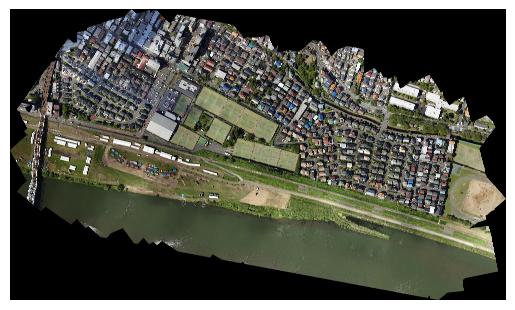

In [ ]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
import numpy as np
from collections import Counter
import os

yolo_model_path = r"C:\Users\dimag\Desktop\28\last.pt"
image_path = r"C:\Users\dimag\Desktop\24bfc3f8-1ff1-47dd-b06a-7e8f95a57c5f.tif"
output_path = r"C:\Users\dimag\Desktop\output_with_detections3.png"
tiles_output_dir = os.path.join(os.path.dirname(image_path), 'test_tails')
os.makedirs(tiles_output_dir, exist_ok=True)

model = YOLO(yolo_model_path)

try:
    Image.MAX_IMAGE_PIXELS = None  
    img = Image.open(image_path)
    img = img.convert("RGB")
except Exception as e:
    print(f"Error loading image: {e}")
    raise

img_width, img_height = img.size

tile_size = 4096
overlap = int(tile_size * 0.2)
stride = tile_size - overlap

final_image = img.copy()
draw_final = ImageDraw.Draw(final_image)
font = ImageFont.load_default()

seen_objects = []
object_count = 0
class_counter = Counter()


def calculate_iou(box1, box2):
    box1 = np.array(box1).reshape(-1, 2)
    box2 = np.array(box2).reshape(-1, 2)
    x1_min, y1_min = np.min(box1[:, 0]), np.min(box1[:, 1])
    x1_max, y1_max = np.max(box1[:, 0]), np.max(box1[:, 1])
    x2_min, y2_min = np.min(box2[:, 0]), np.min(box2[:, 1])
    x2_max, y2_max = np.max(box2[:, 0]), np.max(box2[:, 1])

    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_min < inter_x_max and inter_y_min < inter_y_max:
        intersection = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    else:
        intersection = 0

    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0


def is_near(existing_coords, new_coords, threshold=50):
    existing_center = np.mean(np.array(existing_coords).reshape(-1, 2), axis=0)
    new_center = np.mean(np.array(new_coords).reshape(-1, 2), axis=0)
    return np.linalg.norm(existing_center - new_center) < threshold


def is_center_inside(existing_coords, new_coords):
    new_center = np.mean(np.array(new_coords).reshape(-1, 2), axis=0)
    existing_box = np.array(existing_coords).reshape(-1, 2)
    x_min, y_min = np.min(existing_box[:, 0]), np.min(existing_box[:, 1])
    x_max, y_max = np.max(existing_box[:, 0]), np.max(existing_box[:, 1])
    return x_min <= new_center[0] <= x_max and y_min <= new_center[1] <= y_max


for top in range(0, img_height, stride):
    for left in range(0, img_width, stride):
        right = min(left + tile_size, img_width)
        bottom = min(top + tile_size, img_height)
        tile = img.crop((left, top, right, bottom))

        tile_output_path = os.path.join(tiles_output_dir, f"tile_{top}_{left}.png")
        tile.save(tile_output_path)
        
        results = model.predict(source=tile, imgsz=2048)

        if results and results[0].obb is not None:
            obb_boxes = results[0].obb.xyxyxyxy.cpu().numpy()
            confs = results[0].obb.conf.cpu().numpy() 
            classes = results[0].obb.cls.cpu().numpy() 
            names = results[0].names

            for i, obb_box in enumerate(obb_boxes):
                coords = obb_box.flatten()
                conf = confs[i]
                class_idx = int(classes[i])
                label = f"{names[class_idx]} {conf:.2f}"

                adjusted_coords = [(coords[j] + left if j % 2 == 0 else coords[j] + top) for j in range(len(coords))]

                overlapping = False
                for j, existing in enumerate(seen_objects):
                    if is_near(existing['coords'], adjusted_coords) or is_center_inside(existing['coords'], adjusted_coords):
                        existing_area = np.abs(np.cross(np.array(existing['coords']).reshape(-1, 2)[1] - np.array(existing['coords']).reshape(-1, 2)[0],
                                                       np.array(existing['coords']).reshape(-1, 2)[2] - np.array(existing['coords']).reshape(-1, 2)[0]))
                        new_area = np.abs(np.cross(np.array(adjusted_coords).reshape(-1, 2)[1] - np.array(adjusted_coords).reshape(-1, 2)[0],
                                                   np.array(adjusted_coords).reshape(-1, 2)[2] - np.array(adjusted_coords).reshape(-1, 2)[0]))
                        if new_area > existing_area:
                            seen_objects[j] = {'coords': adjusted_coords, 'conf': conf, 'class_idx': class_idx} 
                        overlapping = True
                        break

                if overlapping:
                    continue

                seen_objects.append({'coords': adjusted_coords, 'conf': conf, 'class_idx': class_idx})
                object_count += 1
                class_counter[class_idx] += 1

                draw_final.polygon(adjusted_coords, outline="red", width=1)

                min_x, min_y = np.min(adjusted_coords[::2]), np.min(adjusted_coords[1::2])
                text_offset = 6  
                draw_final.rectangle([min_x, min_y - text_offset - 10, min_x + len(label) * 6, min_y - text_offset], fill="black")
                draw_final.text((min_x, min_y - text_offset - 10), label, fill="white", font=font)


final_image.save(output_path, format="PNG")
print(f"Processed image saved to {output_path}")
print(f"Total detected objects: {object_count}")

for class_idx, count in class_counter.items():
    print(f"{names[class_idx]}: {count}")

plt.imshow(final_image)
plt.axis("off")
plt.show()


Попередні версії

In [ ]:
import torch


checkpoint = torch.load(r"C:\Users\dimag\Desktop\detect_results_dota_big_3ep\obb\train6\weights\last.pt")

model = checkpoint['model']

model.eval()

print(checkpoint.keys())


dict_keys(['date', 'version', 'license', 'docs', 'epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'train_metrics', 'train_results'])


In [ ]:
model = YOLO(r"C:\Users\dimag\Desktop\detect_results_dota_big_3ep\obb\train6\weights\best.pt") 

results = model.predict(source=r"C:\Users\dimag\Desktop\156.png", imgsz=1024, save=True)

print(res)

if results[0] is not None:
    obb_boxes = results[0].obb.xyxy
    for obb_box in obb_boxes:
        print(f"OBB Box: {obb_box}")
else:
    print("No detections.")


image 1/1 C:\Users\dimag\Desktop\156.png: 736x1024 2959.0ms
Speed: 13.0ms preprocess, 2959.0ms inference, 54.0ms postprocess per image at shape (1, 3, 736, 1024)
Results saved to runs\obb\predict5
[ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'plane', 1: 'ship', 2: 'storage tank', 3: 'baseball diamond', 4: 'tennis court', 5: 'basketball court', 6: 'ground track field', 7: 'harbor', 8: 'bridge', 9: 'large vehicle', 10: 'small vehicle', 11: 'helicopter', 12: 'roundabout', 13: 'soccer ball field', 14: 'swimming pool', 15: 'container crane'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[166, 164, 167],
        [168, 169, 171],
        [170, 173, 176],
        ...,
        [142, 136, 134],
        [148, 140, 140],
        [156, 146, 148]],

       [[165, 162, 165],
        [168, 165, 168],
        [169, 171, 173],
        ...,
        [143, 135, 138],
        [148, 142, 145],
        [150, 144, 147]],

      